# 4 Estimando rotações
***Uma introdução ao filtro de Kalman***

Neste notebook usamos os valores capturados anteriormente pela IMU para obter estimativas de rotação do robô.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

- d1, d2, d3 e d4 são as medidas com o robô na horizontal, sendo rotacionado 90° em sentido anti horário
- d5 é uma medida na horizontal, d6 é o robô na mesma orientação, mas inclinado no cubo
- d7 é a medida do ângulo sendo variado

In [2]:
d1 = np.loadtxt("d1.txt", delimiter=',')
d2 = np.loadtxt("d2.txt", delimiter=',')
d3 = np.loadtxt("d3.txt", delimiter=',')
d4 = np.loadtxt("d4.txt", delimiter=',')
d5 = np.loadtxt("d5.txt", delimiter=',')[:6000]
d6 = np.loadtxt("d6.txt", delimiter=',')[:6000]
d7 = np.loadtxt("d7.txt", delimiter=',')[:9000]

In [3]:
# constante de calibração obtida na parte 3
const_calib = np.array([-875.3921673, 78.78981146, -602.70722089, 1.00382402, 1.00611237, 0.98828275])
# constante de escala da IMU
scale = 0.000598

In [4]:
def calc_accel(medida, const_calib, scale):
    rx, ry, rz = medida
    rx = scale*const_calib[3]*(rx+const_calib[0])
    ry = scale*const_calib[4]*(ry+const_calib[1])
    rz = scale*const_calib[5]*(rz+const_calib[2])
    return [rx,ry,rz]


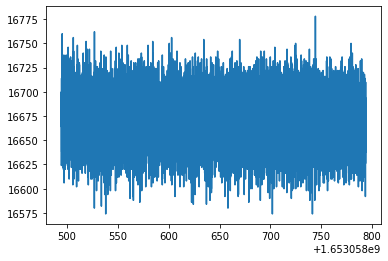

In [5]:
# amostra das leituras brutas do eixo y da primeira medida
plt.plot(d1[:,6]*1e-9, d1[:,2])

In [6]:
# vetores de leituras brutas
v1 = (np.average(d1[:,0]), np.average(d1[:,1]), np.average(d1[:,2]))
v2 = (np.average(d2[:,0]), np.average(d2[:,1]), np.average(d2[:,2]))
v3 = (np.average(d3[:,0]), np.average(d3[:,1]), np.average(d3[:,2]))
v4 = (np.average(d4[:,0]), np.average(d4[:,1]), np.average(d4[:,2]))

v5 = (np.average(d5[:,0]), np.average(d5[:,1]), np.average(d5[:,2]))
v6 = (np.average(d6[:,0]), np.average(d5[:,1]), np.average(d6[:,2]))

v7 = (np.average(d7[:,0]), np.average(d7[:,1]), np.average(d7[:,2]))

---

## 4.3.2  Determinando transformação de coordenadas da IMU para o robô

**Obtendo o ângulo da posição neutra da IMU**

Aqui usamos as medidas das quatro orientações do robô para obter o vetor de ângulo da posição neutra da IMU, sem o viés de um piso não horizontal.

In [7]:
#vetores de acelerações que formam o cone
a1 = calc_accel(v1, const_calib, scale)
a2 = calc_accel(v2, const_calib, scale)
a3 = calc_accel(v3, const_calib, scale)
a4 = calc_accel(v4, const_calib, scale)
print(a1,'\n', a2,'\n', a3, '\n', a4)

a5 = calc_accel(v5, const_calib, scale)
a6 = calc_accel(v6, const_calib, scale)

[-2.203308966666739, -0.037952041955073894, 9.495305584025344] 
 [-2.199882689894526, -0.08095939832422727, 9.489319454471982] 
 [-2.250210251955521, -0.06951848353451705, 9.476980070461169] 
 [-2.234023719460928, -0.02155156304331003, 9.481684769409178]


In [8]:
a_media = np.mean([a1, a2, a3, a4],axis=0)
a_media

array([-2.22185641, -0.05249537,  9.48582247])

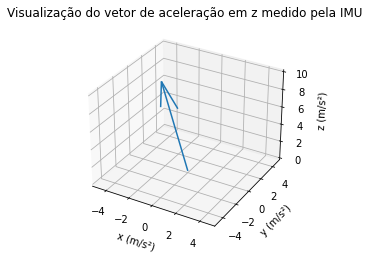

In [9]:
# visualização do vetor de aceleração medido pela IMU enquanto montada no robô
# (com o robô apoiado sobre uma superfície plana)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, a_media[0], a_media[1], a_media[2])
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([0, 10])

plt.title("Visualização do vetor de aceleração em z medido pela IMU")
ax.set_xlabel("x (m/s²)")
ax.set_ylabel("y (m/s²)")
ax.set_zlabel("z (m/s²)")
plt.show()

**Obtendo os dois outros vetores da base no referencial da IMU**

In [10]:
vetor_k = a_media/np.linalg.norm(a_media)
vetor_k

array([-0.22805342, -0.00538817,  0.97363371])

In [11]:
d = np.subtract(a5, a6)
vetor_j = np.cross(d, vetor_k)
vetor_j /= np.linalg.norm(vetor_j)
vetor_j

array([-2.96860667e-04,  9.99985026e-01,  5.46447122e-03])

In [12]:
vetor_i = np.cross(vetor_j, vetor_k)
vetor_i

array([ 9.73648575e-01, -9.57157821e-04,  2.28051609e-01])

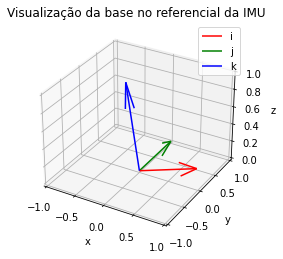

In [13]:
# visualização da base no referencial da IMU

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, vetor_i[0], vetor_i[1], vetor_i[2], color='red', label='i')
ax.quiver(0, 0, 0, vetor_j[0], vetor_j[1], vetor_j[2], color='green', label='j')
ax.quiver(0, 0, 0, vetor_k[0], vetor_k[1], vetor_k[2], color='blue', label='k')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 1])

plt.title("Visualização da base no referencial da IMU")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()
plt.show()

In [14]:
# função que rotaciona o vetor de acelerações medidas pela IMU
# para que elas estejam de acordo com o referencial do robô
def imu2robo(aceleracao_imu, vetor_i, vetor_j, vetor_k):
  rotacao = [vetor_i,
             vetor_j,
             vetor_k]
  return np.dot(rotacao,aceleracao_imu)

---

## 4.4 Estimando a inclinação do robô pelo acelerômetro

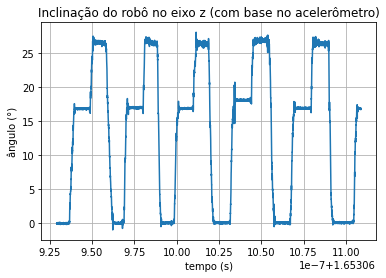

In [15]:
# obtendo a inclinação do robô pelo acelerômetro
v7 = np.array([imu2robo(calc_accel(m[:3], const_calib, scale), vetor_i, vetor_j, vetor_k) for m in d7])
v7_angles =  90 - 180/np.pi*np.arctan2(v7[:,2],v7[:,0])
plt.grid()
plt.title("Inclinação do robô no eixo z (com base no acelerômetro)")
plt.xlabel("tempo (s)")
plt.ylabel("ângulo (°)")
plt.plot(d7[:,6]*1e-18, v7_angles)

Podemos ver que há um ruído constante na medição.

---

## 4.5 Estimando a inclinação do robô por integração do giroscópio

Vamos primeiro calcular o viés do giroscópio utilizando a medida d5, onde o robô estava parado.

In [16]:
scale_gir = 0.001064724
vies_gir = (np.average(d5[:,3]), np.average(d5[:,4]), np.average(d5[:,5]))
vies_gir

(-17.27, 69.42866666666667, 27.418666666666667)

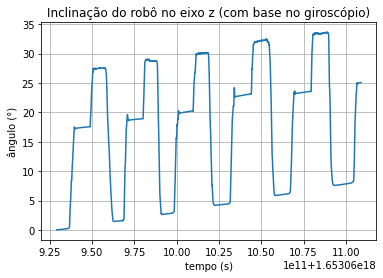

In [17]:
angulo = [0]
t_velho = d7[0][6]
w_t = [imu2robo((d7[0][3:6]-vies_gir)*scale_gir, vetor_i, vetor_j, vetor_k)[1]]
for i in d7[1:]:
  dt = i[6] - t_velho
  acel_ang_robo = imu2robo((i[3:6]-vies_gir)*scale_gir, vetor_i, vetor_j, vetor_k)
  w_t.append(acel_ang_robo[1]*180/np.pi)
  angulo.append(angulo[-1]-w_t[-1]*dt*1e-9)
  t_velho = i[6]
plt.grid()
plt.title("Inclinação do robô no eixo z (com base no giroscópio)")
plt.xlabel("tempo (s)")
plt.ylabel("ângulo (°)")
plt.plot(d7[:,6], angulo)

Não há mais um grande ruído na medição, porém, existe uma deriva.

---

## 4.6 Fusão sensorial: Um filtro de Kalman trivial de uma dimensão

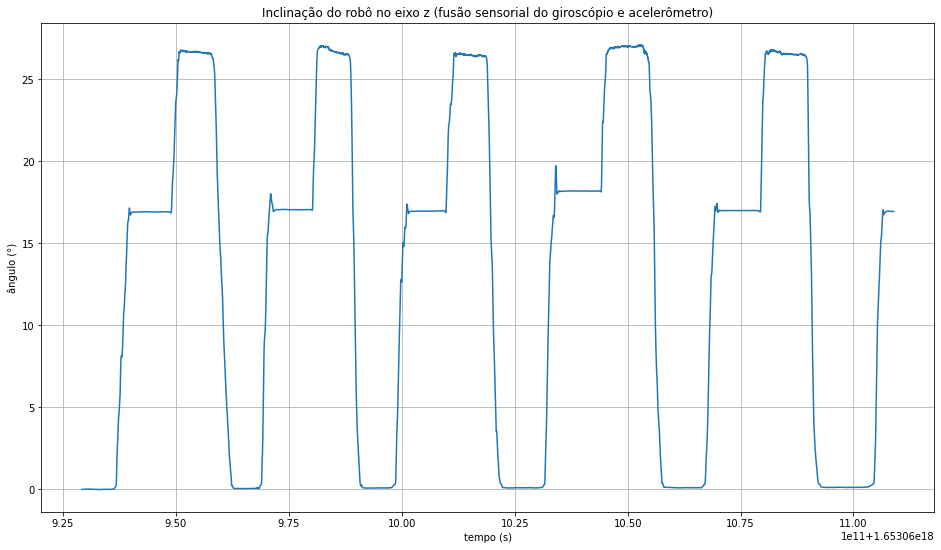

In [18]:
# estimando o Ângulo por filtro de Kalman

w_t = np.array(w_t)
phi_t = v7_angles
# veiculo parado
# angulo pela aceleração
v4 = np.array([imu2robo(calc_accel(m[:3], const_calib, scale), vetor_i, vetor_j, vetor_k) for m in d5])
v4_angles =  90 - 180/np.pi*np.arctan2(v4[:,2],v4[:,0])
r2 = np.var(v4_angles)
# velocidade angular
sigma_w2 = np.var(d4[:,4])

q2 = 0.005 #covariancia de del t

sigma2_old = 0
mi_t = [0]
t_old = d7[0][6]
k_pl = [0]
dt_plt = [0]
for i in range(1,len(d7)):
  dt = d7[i][6] - t_old
  dt_plt.append(dt)
  sigma_barra2 = sigma2_old + r2*dt*1e-9*dt*1e-9 #4.12

  k = sigma_barra2 / (sigma_barra2+q2)  #4.13
  k_pl.append(k)
  sigma2 = (1-k)*sigma_barra2 #4.15

  u = -w_t[i]*dt*1e-9
  mi_barra = mi_t[-1] + u #4.11

  mi_t.append(mi_barra + k*(phi_t[i] - mi_barra)) #4.14

  t_old = d7[i][6]
  sigma2_old = sigma2

plt.figure(figsize=(16,9))
plt.grid()
plt.title("Inclinação do robô no eixo z (fusão sensorial do giroscópio e acelerômetro)")
plt.xlabel("tempo (s)")
plt.ylabel("ângulo (°)")
plt.plot(d7[:,6], mi_t)

Agora temos uma medida com baixo ruído e sem deriva.